**Saudi stock market prediction with simple summarized info about the chosen company**

For the prediction, I have used scikit-learn’s linear regression. The prediction is quite basic and should not be taken seriously, as I do not have enough data to build a robust prediction engine.

For the summary, I initially used a library to fetch information from Wikipedia pages and processed the text using a pipeline created by malmarjeh on Hugging Face, specifically the model “malmarjeh/mbert2mbert-arabic-text-summarization.” I also tried using “aubmindlab/aragpt2-large,” a GPT-2 based text generation model, but the outputs were not reliable.

The first thing to discuss is the data. 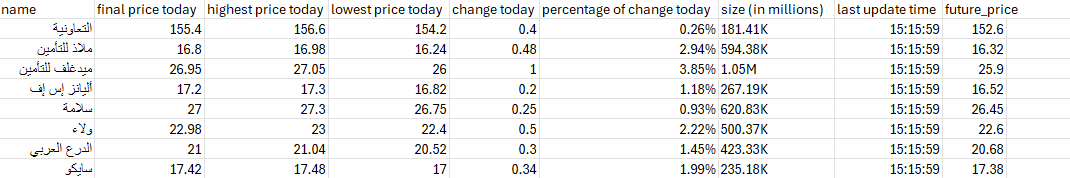 Free data for the Saudi stock market is not easy to obtain. Therefore, I used the list from sa.investing.com, which shows daily market prices. I collected data from two different days: Day 1 for the main data and Day 2 for the price, to perform the regression. A sample is shown above.

I used pandas to manipulate the sheets and scikit-learn for the prediction. Then, I initiated the model for the summary. After that, I created a simple function to plot the price difference, with a rule to make the plot clearer if the difference is small.

The main function starts by getting the name of the company and follows these steps to complete the task: first, fetch the Wikipedia text, then retrieve the necessary data from the Excel sheet, and put it into the pipeline for prediction. Finally, the information and the Wikipedia text are used to generate the summary and data prediction.

finally I used gradio to make the interface.

In [3]:
# installing requairments
!pip install transformers
!pip install nltk
!pip install protobuf
!pip install sentencepiece
!pip install Cython
!pip install gradio
!pip install wikipedia
!pip install arabert

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.1/18.1 MB 48.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.7/318.7 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.0/94.0 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 81.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.4/71.4 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 9.0 MB/s eta 0:00:00
  Attempting uninstall: tomlkit
    Found existing in

In [8]:
import pandas as pd
import gradio as gr
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from transformers import pipeline
import numpy as np
import matplotlib.pyplot as plt
import wikipedia
from transformers import BertTokenizer, AutoModelForSeq2SeqLM, pipeline
from arabert.preprocess import ArabertPreprocessor

# Load the Excel sheet
df = pd.read_excel('/content/stock_data.xlsx')


# Prepare the data for the model
X = df[['final price today', 'change today']].values
y = df['future_price'].values

"""
 Create a pipeline with a scaler and a linear regression model
 scaler is used to standrlize the data and make the model more accurate.
 and the linear regression model is used to predict the future price.

"""

model_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', LinearRegression())
])

# Train the pipeline
model_pipeline.fit(X, y)

# Initialize the summary generation pipeline
model_name="malmarjeh/mbert2mbert-arabic-text-summarization"
preprocessor = ArabertPreprocessor(model_name="")
tokenizer = BertTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
pipeline = pipeline("text2text-generation",model=model,tokenizer=tokenizer)

# function for building the plot
def plot_stock_prices(stock_name, current_price, future_price):
    plt.figure(figsize=(10, 20))

    # Plot the bar chart
    plt.bar(['Final Price Today', 'Predicted Future Price'], [current_price, future_price], color=['blue', 'green'])

    # Add labels and title
    plt.xlabel('Price Type')
    plt.ylabel('Price')
    plt.title(f'Stock Prices for {stock_name}')

    # Annotate the bars with the actual values
    plt.text(0, current_price, f'{current_price:.2f}', ha='center', va='bottom')
    plt.text(1, future_price, f'{future_price:.2f}', ha='center', va='bottom')

    # Adjust y-axis limits if the difference is very small
    if abs(current_price - future_price) < 1:
        plt.ylim(min(current_price, future_price) - 1, max(current_price, future_price) + 1)

    # Save the plot
    plt.savefig('/content/sample_data/graph.png')
    plt.close()

# Function to get stock information and predict future price and make the summary
def get_stock_info(stock_name):
    # check if the name in the list
    stock_info = df[df['name'] == stock_name]
    if stock_info.empty:

        # Return a message and an empty graph
        plt.figure(figsize=(10, 6))
        plt.text(0.5, 0.5, 'Stock not found', horizontalalignment='center', verticalalignment='center', fontsize=12)
        plt.axis('off')
        plt.savefig('not_found.png')
        plt.close()
        return {"Error": "Stock not found"}, 'not_found.png', 'training_plot.png'

    else:
        # Set Wikipedia language to Arabic
        wikipedia.set_lang("ar")
        try:
          # searching with the stock name and note that the use of the words "شركة" and "السعودية" is to make sure the search is about companies in saudi market
            wiki_summary = wikipedia.summary("شركة "+ stock_name + " السعودية", sentences=5)
        except wikipedia.exceptions.DisambiguationError as e:
            wiki_summary = f"Multiple entries found for {stock_name}: {e.options}"
        except wikipedia.exceptions.PageError:
            wiki_summary = "Wikipedia page not found for this company."
        # Setting the data to make the prediction and summary
        info = stock_info.iloc[0]
        current_price = info['final price today']
        change_today = info['change today']
        # making the prediction
        future_price = model_pipeline.predict([[current_price, change_today]])[0]
        summary_prompt = f"سهم شركة {stock_name} سعره الحالي{current_price} اليوم مع تغيير قدره {change_today}. ويتوقع ان يصبح سعره {future_price} والجدير بالذكر ان "
        text = preprocessor.preprocess(wiki_summary)
        # building the summary
        summary = pipeline(text,
            pad_token_id=tokenizer.eos_token_id,
            num_beams=3,
            repetition_penalty=3.0,
            max_length=300,
            length_penalty=1.0,
            no_repeat_ngram_size = 3)[0]['generated_text']

        # Plotting the graph
        graph = plot_stock_prices('Example Stock', current_price, future_price)


        return {
            "اخر قيمة لليوم": current_price,
            "اعلى قيمة لليوم": info.get('highest price today', 'N/A'),
            "اقل قيمة لليوم": info.get('lowest price today', 'N/A'),
            "التغير": change_today,
            "نسبة التغير": info.get('percentage of change today', 'N/A'),
            "الحجم": info.get('size', 'N/A'),
            "اخر تحديث (بالساعة)": info.get('last update time', 'N/A'),
            "السعر المتوقع": future_price,
            "التوقع والملخص": summary_prompt + summary,
            "مقال ويكيبيديا الكامل": wiki_summary
        }, "/content/sample_data/graph.png"

# Create the Gradio interface
iface = gr.Interface(
    fn=get_stock_info,
    inputs=gr.Textbox(label="اسم السهم"),
    outputs=[gr.JSON(), gr.Image()],
    title="توقع اسعار سوق الاسهم السعودي",
    description="الرجاء ادخال اسم الشركة لاظهار التوقع ومعلومات عامة عن الشركة"

)

# Launch the interface with debug=True for error handling
iface.launch(debug=True)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
The following encoder weights were not tied to the decoder ['bert/pooler']
The following encoder weights were not tied to the decoder ['bert/pooler']
The following encoder weights were not tied to the decoder ['bert/pooler']
The following encoder weights were not tied to the decoder ['bert/pooler']


Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://1c71ed8bbd8e8e4082.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


Setting `pad_token_id` to `eos_token_id`:102 for open-end generation.


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://1c71ed8bbd8e8e4082.gradio.live
